## downsc: https://github.com/robbiewatt1/ClimateDiffuse/tree/main
!git clone https://github.com/robbiewatt1/ClimateDiffuse.git
!pip install tensorboard

In [1]:
import os
#os.environ ['PROJ_LIB'] = '/home/mpyrina/.conda/envs/myenv_Feb21/share/proj'
#from mpl_toolkits.basemap import Basemap
import matplotlib
from netCDF4 import Dataset
import glob
import pandas as pd
import xarray as xr
import numpy as np 
import matplotlib.pyplot as plt
import seaborn
from matplotlib import pyplot

import sklearn

# Check version
print(sklearn.__version__)

1.3.0


In [2]:
# Imports
import sys
import matplotlib.pyplot as plt
import cartopy
import torch

%matplotlib inline
%load_ext autoreload
%autoreload 2

sys.path.append('/home/mpyrina/Notebooks/ANEMOI/ClimateDiffuse/src/')
from DatasetCH import *
from TrainDiffusion import *
from TrainUnet import *

In [ ]:
print(sklearn.__version__)

In [3]:
print(sys.path)

['/home/mpyrina/Notebooks/ANEMOI/ClimateDiffuse/src', '/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python311.zip', '/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python3.11', '/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python3.11/lib-dynload', '', '/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python3.11/site-packages', '/home/mpyrina/Notebooks/ANEMOI/ClimateDiffuse/src/', '/tmp/tmp8ztowi_i']


## A. Test ifs data

In [3]:
import torch
import torchvision
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

data_dir='/s2s/mpyrina/ECMWF_MCH/Europe_eval/s2s_hind_2022/all/'
in_shape=(32, 16) # shape of latlon of low resolution image LON,LAT: is cut in processing 32,16
out_shape=(241, 103) # shape of latlon of high resolution image LON,LAT 256,128
time_dim=46

year_list=[2019,2020,2021]
year_start=20200815; year_end=20200822

west, east = 2, 14.4
south, north = 44.4, 50.4

# A. Import some hincast data of the ECMWF original data, which have Dimensions: time: 46 x_1: 296 y_1: 131 epsd_1: 11
# and cut into a smaller region

# list of original data names and names with paths
filenames = [f"IFS_EXT_HC_{year}0815_T_2M.nc" for cc, year in enumerate(year_list)]
filepaths = [data_dir + filename for filename in filenames]
# open them with xarray
ds_0 = xr.open_mfdataset(filepaths[0],engine='netcdf4') # example to see original dimensions 296, 131
ds_all = xr.open_mfdataset(filepaths,engine='netcdf4')

# CREATE the new model file being a smaller region
model_CH=ds_all.sel(x_1=slice(west, east)).sel(y_1=slice(south, north))
#model_CH.to_netcdf(data_dir + f"IFS_EXT_HC_{year_list[0]}_{year_list[-1]}_T_2M.nc", format="NETCDF4")
print('dataset created')

dataset created


In [4]:
ds_0

<xarray.Dataset>
Dimensions:         (time: 46, x_1: 296, y_1: 131, epsd_1: 11)
Coordinates:
  * time            (time) datetime64[ns] 2019-08-16 2019-08-17 ... 2019-09-30
  * x_1             (x_1) float32 -42.0 -41.6 -41.2 -40.8 ... 75.2 75.6 76.0
  * y_1             (y_1) float32 24.0 24.4 24.8 25.2 ... 74.8 75.2 75.6 76.0
    lon_1           (y_1, x_1) float32 dask.array<chunksize=(131, 296), meta=np.ndarray>
    lat_1           (y_1, x_1) float32 dask.array<chunksize=(131, 296), meta=np.ndarray>
  * epsd_1          (epsd_1) int32 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    grid_mapping_1  |S1 ...
    T_2M            (time, epsd_1, y_1, x_1) float32 dask.array<chunksize=(46, 11, 131, 296), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     European Centre for Medium-Range Weather Forecasts (ECMWF)
    source:          model: ifs-ens, production_status: unknown, version: 1, ...
    history:         Produced by fieldextra version v14.0.2 (prod_test_passed...

In [5]:
model_CH

<xarray.Dataset>
Dimensions:         (time: 138, x_1: 18, y_1: 11, epsd_1: 11)
Coordinates:
  * time            (time) datetime64[ns] 2019-08-16 2019-08-17 ... 2021-09-30
  * x_1             (x_1) float32 4.8 5.2 5.6 6.0 6.4 ... 10.4 10.8 11.2 11.6
  * y_1             (y_1) float32 44.8 45.2 45.6 46.0 ... 47.6 48.0 48.4 48.8
    lon_1           (y_1, x_1) float32 dask.array<chunksize=(11, 18), meta=np.ndarray>
    lat_1           (y_1, x_1) float32 dask.array<chunksize=(11, 18), meta=np.ndarray>
  * epsd_1          (epsd_1) int32 0 1 2 3 4 5 6 7 8 9 10
Data variables:
    grid_mapping_1  (time) |S1 b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    T_2M            (time, epsd_1, y_1, x_1) float32 dask.array<chunksize=(46, 11, 11, 18), meta=np.ndarray>
Attributes:
    Conventions:     CF-1.6
    ConventionsURL:  http://cfconventions.org/cf-conventions/v1.6.0/cf-conven...
    institution:     European Centre for Medium-Range Weather Forecasts (ECMWF)
    source:          model: ifs-ens, production_status: unknown, version: 1, ...
    history:         Produced by fieldextra version v14.0.2 (prod_test_passed...

## B. OBS  DATA


In [4]:
era_in='/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000.nc'
era_file = xr.open_dataset(era_in)
era_file

<xarray.Dataset>
Dimensions:             (time: 12661, lon: 241, lat: 103)
Coordinates:
  * time                (time) datetime64[ns] 1990-01-01 ... 2022-12-31
  * lon                 (lon) float64 5.75 5.771 5.792 ... 10.71 10.73 10.75
  * lat                 (lat) float64 45.75 45.77 45.79 ... 47.83 47.85 47.88
Data variables:
    longitude_latitude  float64 ...
    TabsD               (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Jul 18 17:46:34 2023: cdo cat TabsD_ch02.lonlat_1990010...
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [5]:
print(era_file['TabsD'])
print(era_file['TabsD'].shape)

<xarray.DataArray 'TabsD' (time: 12661, lat: 103, lon: 241)>
[314284003 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2022-12-31
  * lon      (lon) float64 5.75 5.771 5.792 5.812 ... 10.69 10.71 10.73 10.75
  * lat      (lat) float64 45.75 45.77 45.79 45.81 ... 47.81 47.83 47.85 47.88
Attributes:
    long_name:     daily mean temperature
    units:         degree
    grid_mapping:  longitude_latitude
    grid_name:     ch02.lonlat
    version:       v1.2
    prod_date:     2021-09-07 19:18:26
(12661, 103, 241)


#### expand latlon

In [5]:
import xarray as xr
import numpy as np

era_in = '/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000.nc'
ds = xr.open_dataset(era_in)

print("--- Original Dataset Information ---")
print(f"Original Dimensions: {ds.dims}")
print(f"Original 'TabsD' shape: {ds['TabsD'].shape}")
print(f"Original Longitude Range: {ds.lon.min().item():.6f} to {ds.lon.max().item():.6f}")
print(f"Original Latitude Range: {ds.lat.min().item():.6f} to {ds.lat.max().item():.6f}")

# --- Important: Verify an original data point's value ---
# Let's pick an arbitrary original data point to check its value before and after reindexing.
# We'll use the first available time, lat, and lon index.
original_test_value = ds['TabsD'].isel(time=0, lat=0, lon=0).item()
original_test_lon = ds.lon.isel(lon=0).item()
original_test_lat = ds.lat.isel(lat=0).item()
print(f"\nValue of TabsD at original [time=0, lat={original_test_lat:.6f}, lon={original_test_lon:.6f}]: {original_test_value:.6f}")

# 2. Calculate the precise spacing of your existing grid points
lon_spacing = ds.lon.diff(dim='lon').mean().item()
lat_spacing = ds.lat.diff(dim='lat').mean().item()

print(f"\nCalculated Grid Spacing:")
print(f"  Longitude step: {lon_spacing:.10f}") # Print more decimal places for precision check
print(f"  Latitude step:  {lat_spacing:.10f}")  # Print more decimal places for precision check

# 3. Define the new total number of points for each dimension
new_total_lon_points = 256
new_total_lat_points = 128

# 4. Generate the *additional* longitude and latitude points
#    We create only the points that come AFTER the last original point.
num_additional_lon_points = new_total_lon_points - ds.lon.size
num_additional_lat_points = new_total_lat_points - ds.lat.size

if num_additional_lon_points < 0 or num_additional_lat_points < 0:
    raise ValueError("New total points must be greater than or equal to current points.")

# Calculate the values for the additional longitude points
last_original_lon = ds.lon.max().item()
# We start from (last_original_lon + lon_spacing)
additional_lon_values = [last_original_lon + (i + 1) * lon_spacing for i in range(num_additional_lon_points)]
# Ensure numpy array for concatenation
additional_lon_values = np.array(additional_lon_values)

# Calculate the values for the additional latitude points
last_original_lat = ds.lat.max().item()
# We start from (last_original_lat + lat_spacing)
additional_lat_values = [last_original_lat + (i + 1) * lat_spacing for i in range(num_additional_lat_points)]
# Ensure numpy array for concatenation
additional_lat_values = np.array(additional_lat_values)


# 5. Concatenate the original coordinates with the newly generated additional points
extended_lon = np.concatenate((ds.lon.values, additional_lon_values))
extended_lat = np.concatenate((ds.lat.values, additional_lat_values))

print(f"\nTarget Grid Sizes:")
print(f"  New total longitude points: {len(extended_lon)}")
print(f"  New total latitude points: {len(extended_lat)}")
print(f"  First 5 extended lon: {extended_lon[:5]}")
print(f"  Last 5 extended lon: {extended_lon[-5:]}")
print(f"  First 5 extended lat: {extended_lat[:5]}")
print(f"  Last 5 extended lat: {extended_lat[-5:]}")

# 6. Use .reindex() to expand the dimensions and fill new areas with the specified fill_value
# This will now correctly preserve existing data and fill only the new areas.
ds_expanded = ds.reindex(lon=extended_lon, lat=extended_lat, fill_value=np.nan) # 
ds_expanded.to_netcdf('/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000_expanded.nc')

print("\n--- Expanded Dataset Information ---")
print(f"Expanded Dimensions: {ds_expanded.dims}")
print(f"Expanded 'TabsD' shape: {ds_expanded['TabsD'].shape}")
print(f"Expanded Longitude Range: {ds_expanded.lon.min().item():.6f} to {ds_expanded.lon.max().item():.6f}")
print(f"Expanded Latitude Range: {ds_expanded.lat.min().item():.6f} to {ds_expanded.lat.max().item():.6f}")

--- Original Dataset Information ---
Original Dimensions: Frozen({'time': 12661, 'lon': 241, 'lat': 103})
Original 'TabsD' shape: (12661, 103, 241)
Original Longitude Range: 5.750000 to 10.750000
Original Latitude Range: 45.750000 to 47.875000

Value of TabsD at original [time=0, lat=45.750000, lon=5.750000]: nan

Calculated Grid Spacing:
  Longitude step: 0.0208333333
  Latitude step:  0.0208333333

Target Grid Sizes:
  New total longitude points: 256
  New total latitude points: 128
  First 5 extended lon: [5.75       5.77083333 5.79166667 5.8125     5.83333333]
  Last 5 extended lon: [10.97916667 11.         11.02083333 11.04166667 11.0625    ]
  First 5 extended lat: [45.75       45.77083333 45.79166667 45.8125     45.83333333]
  Last 5 extended lat: [48.3125     48.33333333 48.35416667 48.375      48.39583333]

--- Expanded Dataset Information ---
Expanded Dimensions: Frozen({'time': 12661, 'lon': 256, 'lat': 128})
Expanded 'TabsD' shape: (12661, 128, 256)
Expanded Longitude Range

In [6]:
ds_expanded 

<xarray.Dataset>
Dimensions:             (time: 12661, lon: 256, lat: 128)
Coordinates:
  * time                (time) datetime64[ns] 1990-01-01 ... 2022-12-31
  * lon                 (lon) float64 5.75 5.771 5.792 ... 11.02 11.04 11.06
  * lat                 (lat) float64 45.75 45.77 45.79 ... 48.35 48.38 48.4
Data variables:
    longitude_latitude  float64 ...
    TabsD               (time, lat, lon) float32 nan nan nan nan ... nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Jul 18 17:46:34 2023: cdo cat TabsD_ch02.lonlat_1990010...
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [ ]:
# --- Crucial Verification ---
print("\n--- Verification of Data Preservation ---")

# Verify the same original data point again in the expanded dataset
expanded_test_value = ds_expanded['TabsD'].sel(time=ds.time[0], lat=original_test_lat, lon=original_test_lon, method='nearest').item()
print(f"Value of TabsD at original [time=0, lat={original_test_lat:.6f}, lon={original_test_lon:.6f}] in EXPANDED DS: {expanded_test_value:.6f}")

# Check if the values match (should be True)
print(f"Original value matches expanded value for an existing point: {original_test_value == expanded_test_value}")

# Check a newly added point (should be 0.0)
if num_additional_lon_points > 0:
    first_new_lon_coord = extended_lon[ds.lon.size] # The first lon coordinate that was just added
    new_point_value = ds_expanded['TabsD'].sel(time=ds.time[0], lat=ds.lat[0], lon=first_new_lon_coord, method='nearest').item()
    print(f"Value of TabsD at a NEW longitude point (e.g., lon={first_new_lon_coord:.6f}): {new_point_value:.6f} (Expected: 0.0)")
else:
    print("No new longitude points were added to check for fill_value.")

In [3]:
import xarray as xr
import pandas as pd
import os
import glob

# Paths ... years 21 and 22 are not fixed
bigfile = '/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000_expanded.nc'
ifs_folder = '/s2s/mpyrina/ECMWF_MCH/Europe_eval/s2s_hind_2022/all/'  # Folder where the IFS files are
outdir = '/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/'  # Where to save new subfiles

# Automatically find all IFS files, sorted
ifs_filenames = sorted(glob.glob(os.path.join(ifs_folder, 'IFS_EXT_HC_*_T_2M.nc')))

# Open the big dataset
ds_big = xr.open_dataset(bigfile)

In [10]:
ds_big['TabsD'][0:100, 56, 120]

<xarray.DataArray 'TabsD' (time: 100)>
array([-3.359861, -3.809819, -3.310691, -3.050381, -2.201118,  0.145904,
        0.163781, -1.694776, -2.239685, -2.913095, -3.41404 , -3.744059,
       -3.459311, -3.426198, -0.749348,  2.244024,  1.76536 ,  1.099965,
       -0.573614,  0.267868,  3.094656,  0.398318,  0.832123,  6.180888,
        6.659962,  4.640142,  2.419777,  4.431674,  2.265892,  2.973479,
        4.427319,  5.77041 ,  4.196783,  5.342423,  5.06477 ,  2.645975,
        2.144444,  4.826108,  7.059342,  5.172699,  2.931843,  2.922343,
        2.730614,  4.209107,  8.351363,  8.112819,  1.722278,  4.074877,
        6.966781,  8.008279,  7.397476,  7.410609,  7.561121,  7.674845,
        8.928304, 10.282633, 10.861224,  7.340403,  6.05142 ,  4.201495,
        1.184795,  0.618111,  0.860648,  2.467717,  5.620619,  6.67829 ,
        7.668641, 10.441549,  9.145494,  9.487875, 10.439597,  9.895712,
        8.785134,  8.486524,  8.962346,  7.169053, 10.341013, 10.023135,
        8.679959, 12.265332, 14.403812,  8.992443,  8.244287,  5.083685,
        2.18924 ,  2.239782,  2.262486,  3.672111,  6.574702,  7.570983,
        9.796258, 12.06337 ,  8.5741  ,  5.085278,  5.478706,  5.865519,
        6.218146,  4.212886,  3.079487,  4.293255], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-04-10
    lon      float64 8.25
    lat      float64 46.92
Attributes:
    long_name:     daily mean temperature
    units:         degree
    grid_mapping:  longitude_latitude
    grid_name:     ch02.lonlat
    version:       v1.2
    prod_date:     2021-09-07 19:18:26

In [13]:
ds_big2 = 273.15+(xr.open_dataset(bigfile))
ds_big2['TabsD'][0:100, 56, 120]

<xarray.DataArray 'TabsD' (time: 100)>
array([269.79013, 269.34018, 269.8393 , 270.0996 , 270.94888, 273.2959 ,
       273.31378, 271.45523, 270.9103 , 270.2369 , 269.73596, 269.40594,
       269.69067, 269.7238 , 272.40063, 275.394  , 274.91534, 274.24997,
       272.5764 , 273.41785, 276.24466, 273.5483 , 273.98212, 279.33087,
       279.80997, 277.79013, 275.56976, 277.58167, 275.4159 , 276.12347,
       277.5773 , 278.9204 , 277.34677, 278.49243, 278.21475, 275.79596,
       275.29443, 277.9761 , 280.20935, 278.3227 , 276.08185, 276.07233,
       275.8806 , 277.3591 , 281.50134, 281.26282, 274.87228, 277.22488,
       280.11676, 281.15826, 280.54745, 280.5606 , 280.71112, 280.82483,
       282.0783 , 283.43262, 284.01123, 280.4904 , 279.20142, 277.3515 ,
       274.33478, 273.7681 , 274.01065, 275.6177 , 278.7706 , 279.82828,
       280.81863, 283.59155, 282.2955 , 282.63788, 283.5896 , 283.04572,
       281.93512, 281.6365 , 282.11234, 280.31906, 283.491  , 283.17313,
       281.82996, 285.4153 , 287.5538 , 282.14243, 281.3943 , 278.23367,
       275.33923, 275.38977, 275.41248, 276.8221 , 279.7247 , 280.72098,
       282.94626, 285.21338, 281.7241 , 278.23526, 278.6287 , 279.0155 ,
       279.36813, 277.36288, 276.2295 , 277.44324], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 1990-04-10
    lon      float64 8.25
    lat      float64 46.92

In [14]:
# Make TabsD_expanded to have the IFS array structure
# and remove NANS!!! 

import xarray as xr
import pandas as pd
import os
import glob

# Paths
bigfile = '/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000_expanded.nc'
ifs_folder = '/s2s/mpyrina/ECMWF_MCH/Europe_eval/s2s_hind_2022/all/'  # Folder where the IFS files are
outdir = '/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/'  # Where to save new subfiles

# Automatically find all IFS files, sorted
ifs_filenames = sorted(glob.glob(os.path.join(ifs_folder, 'IFS_EXT_HC_*_T_2M.nc')))

# Open the big TABSD dataset
ds_big = 273.15+(xr.open_dataset(bigfile))

# Loop over IFS filenames
for filepath in ifs_filenames:
    fname = os.path.basename(filepath)[3:]  # Get only filename without path
    print(fname)
    
    # Extract the date part from filename
    date_str = fname.split('_')[3]  # e.g., '20080512'
    date_fn = pd.to_datetime(date_str, format='%Y%m%d') 
    date = date_fn + pd.Timedelta(days=1)
    
    # Check if month is June (6), July (7), or August (8)
    if date_fn.month in [6, 7, 8]:
        print(f"Processing {fname}...")
        
        # Select 46 time steps from the big dataset
        time_sel = ds_big.sel(time=slice(date, date + pd.Timedelta(days=45)))
        
        # Confirm we have exactly 46 time steps
        if len(time_sel.time) != 46:
            print(f"Warning: {fname} - Expected 46 time steps, got {len(time_sel.time)}.")
        
        # --- IMPORTANT: Fill NaNs with 0 here ---
        time_sel_filled = time_sel.fillna(0) # <--- Added this line
        
        # Save the subset
        out_path = os.path.join(outdir, 'TabsD_expanded'+fname)
        time_sel_filled.to_netcdf(out_path)

print("File processing: Done")


_EXT_HC_20020404_T_2M.nc
_EXT_HC_20020407_T_2M.nc
_EXT_HC_20020411_T_2M.nc
_EXT_HC_20020414_T_2M.nc
_EXT_HC_20020418_T_2M.nc
_EXT_HC_20020421_T_2M.nc
_EXT_HC_20020425_T_2M.nc
_EXT_HC_20020428_T_2M.nc
_EXT_HC_20020502_T_2M.nc
_EXT_HC_20020505_T_2M.nc
_EXT_HC_20020509_T_2M.nc
_EXT_HC_20020512_T_2M.nc
_EXT_HC_20020516_T_2M.nc
_EXT_HC_20020519_T_2M.nc
_EXT_HC_20020523_T_2M.nc
_EXT_HC_20020526_T_2M.nc
_EXT_HC_20020530_T_2M.nc
_EXT_HC_20020602_T_2M.nc
Processing _EXT_HC_20020602_T_2M.nc...
_EXT_HC_20020606_T_2M.nc
Processing _EXT_HC_20020606_T_2M.nc...
_EXT_HC_20020609_T_2M.nc
Processing _EXT_HC_20020609_T_2M.nc...
_EXT_HC_20020613_T_2M.nc
Processing _EXT_HC_20020613_T_2M.nc...
_EXT_HC_20020616_T_2M.nc
Processing _EXT_HC_20020616_T_2M.nc...
_EXT_HC_20020620_T_2M.nc
Processing _EXT_HC_20020620_T_2M.nc...
_EXT_HC_20020623_T_2M.nc
Processing _EXT_HC_20020623_T_2M.nc...
_EXT_HC_20020627_T_2M.nc
Processing _EXT_HC_20020627_T_2M.nc...
_EXT_HC_20020630_T_2M.nc
Processing _EXT_HC_20020630_T_2M.nc...

KeyError: "Cannot get left slice bound for non-unique label: Timestamp('2021-06-03 00:00:00')"

In [ ]:
# Create boolean mask where data is valid (not NaN)
# Result will be dtype=bool, same shape as TabsD

import xarray as xr
import numpy as np

# Path to expanded dataset BEFORE fillna(0)
expanded_path = '/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000_expanded.nc'
ds = xr.open_dataset(expanded_path)
mask = ~np.isnan(ds['TabsD'])

# Convert to float32 (optional: PyTorch likes float)
mask = mask.astype(np.float32)

# Create new dataset
mask_ds = xr.Dataset({'mask': mask})

# Save it
mask_ds.to_netcdf('/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/TabsD_mask.nc')
print("Saved mask file.")

#############
# Extract first timestep (assuming time-invariant mask)
static_mask = mask_ds["mask"].isel(time=0)  # shape [lat, lon]

# Remove time dimension, make it 2D [lat, lon]
static_mask.name = "mask"

# Save as new dataset
static_ds = static_mask.to_dataset()
static_ds.to_netcdf('/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/TabsD_mask_static.nc')

print("Saved static mask")

In [13]:
dataset.to_array()[0]

<xarray.DataArray (lat: 128, lon: 256)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    time      datetime64[ns] ...
  * lon       (lon) float64 5.75 5.771 5.792 5.812 ... 11.0 11.02 11.04 11.06
  * lat       (lat) float64 45.75 45.77 45.79 45.81 ... 48.33 48.35 48.38 48.4
    variable  <U4 'mask'

In [4]:
static_ds

<xarray.Dataset>
Dimensions:  (lon: 256, lat: 128)
Coordinates:
    time     datetime64[ns] 1990-01-01
  * lon      (lon) float64 5.75 5.771 5.792 5.812 ... 11.0 11.02 11.04 11.06
  * lat      (lat) float64 45.75 45.77 45.79 45.81 ... 48.33 48.35 48.38 48.4
Data variables:
    mask     (lat, lon) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0

In [2]:
mask_ds

<xarray.Dataset>
Dimensions:  (time: 12661, lon: 256, lat: 128)
Coordinates:
  * time     (time) datetime64[ns] 1990-01-01 1990-01-02 ... 2022-12-31
  * lon      (lon) float64 5.75 5.771 5.792 5.812 ... 11.0 11.02 11.04 11.06
  * lat      (lat) float64 45.75 45.77 45.79 45.81 ... 48.33 48.35 48.38 48.4
Data variables:
    mask     (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

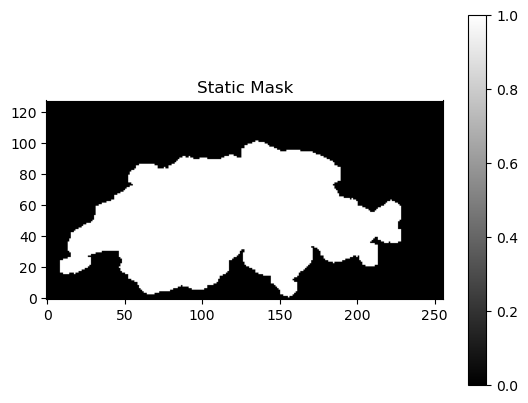

In [15]:
import matplotlib.pyplot as plt
dataset=xr.open_dataset('/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/TabsD_mask_static.nc')
plt.imshow(dataset.to_array()[0], cmap='gray', origin='lower')
plt.title("Static Mask"); plt.colorbar()
plt.show()

In [ ]:
# Make TabsD to have the IFS array structure
import xarray as xr
import pandas as pd
import os
import glob

# Paths
bigfile = '/s2s/mpyrina/ECMWF_MCH/Obs_MCH/TabsD_ch02.lonlat_199001010000_202212310000.nc'
ifs_folder = '/s2s/mpyrina/ECMWF_MCH/Europe_eval/s2s_hind_2022/all/'  # Folder where the IFS files are
outdir = '/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/'  # Where to save new subfiles

# Automatically find all IFS files, sorted
ifs_filenames = sorted(glob.glob(os.path.join(ifs_folder, 'IFS_EXT_HC_*_T_2M.nc')))

# Open the big dataset
ds_big = xr.open_dataset(bigfile)

# Loop over IFS filenames
for filepath in ifs_filenames:
    fname = os.path.basename(filepath)[3:]  # Get only filename without path
    print(fname)
    
    # Extract the date part from filename
    date_str = fname.split('_')[3]  # e.g., '20080512'
    date_fn = pd.to_datetime(date_str, format='%Y%m%d') 
    date = date_fn + pd.Timedelta(days=1)
    
    # Check if month is May (5), June (6), July (7), or August (8)
    if date_fn.month in [5, 6, 7, 8]:
        print(f"Processing {fname}...")
        
        # Select 46 time steps from the big dataset
        time_sel = ds_big.sel(time=slice(date, date + pd.Timedelta(days=45)))
        
        # Confirm we have exactly 46 time steps
        if len(time_sel.time) != 46:
            print(f"Warning: {fname} - Expected 46 time steps, got {len(time_sel.time)}.")
        
        # Save the subset
        out_path = os.path.join(outdir, 'TabsD'+fname)
        time_sel.to_netcdf(out_path)

print("File processing: Done")


In [14]:
filepath = '/s2s/mpyrina/ECMWF_MCH/Obs_MCH/IFS_ch02.lonlat_199001010000_202212310000.nc'
fname = os.path.basename(filepath)[3:]  # Get only filename without path
fname

'_ch02.lonlat_199001010000_202212310000.nc'

In [8]:
obs_dir = '/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/'
obs_file = xr.open_dataset(obs_dir+'TabsD_EXT_HC_20200725_T_2M.nc')
obs_file

<xarray.Dataset>
Dimensions:             (time: 46, lon: 241, lat: 103)
Coordinates:
  * time                (time) datetime64[ns] 2020-07-26 ... 2020-09-09
  * lon                 (lon) float64 5.75 5.771 5.792 ... 10.71 10.73 10.75
  * lat                 (lat) float64 45.75 45.77 45.79 ... 47.83 47.85 47.88
Data variables:
    longitude_latitude  float64 ...
    TabsD               (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Tue Jul 18 17:46:34 2023: cdo cat TabsD_ch02.lonlat_1990010...
    institution:  Federal Office of Meteorology and Climatology MeteoSwiss
    References:   Frei C., 2014: Interpolation of temperatures in a mountaino...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

## S

## OBS Data

## Apply the dataset_upscale function

In [3]:
ifs_dir = '/s2s/mpyrina/ECMWF_MCH/Europe_eval/s2s_hind_2022/all/'
obs_dir = '/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/'

In [4]:
## Select hyperparameters of training
batch_size = 8
learning_rate = 1e-4
accum = 8

# Run training for small number of epochs 
num_epochs = 2        

# Define device
device =  'cuda' if torch.cuda.is_available() else 'cpu'

# define the ml model : 1, 1, : 1 input var, one output
unet_model = UNet((241, 103), 1, 1, label_dim=0, use_diffuse=False)
unet_model.to(device)

UNet(
  (map_layer0): Linear()
  (map_layer1): Linear()
  (enc): ModuleDict(
    (241x103_conv): Conv2d()
    (241x103_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (241x103_block1): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (120x51_down): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (120x51_block0): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
      (skip): Conv2d()
    )
    (120x51_block1): UNetBlock(
      (norm0): GroupNorm()
      (conv0): Conv2d()
      (affine): Linear()
      (norm1): GroupNorm()
      (conv1): Conv2d()
    )
    (60x25_down): UNetB

In [5]:
# Create train and test data
dataset_train = UpscaleDataset(
    coarse_data_dir = ifs_dir, highres_data_dir = obs_dir,
    year_start=2005, year_end=2008, month=815,  
    constant_variables=None, constant_variables_filename=None)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=8, shuffle=True, num_workers=4
)

dataset_test = UpscaleDataset(
    coarse_data_dir = ifs_dir, highres_data_dir = obs_dir,
    year_start=2009, year_end=2010, month=815,  
    constant_variables=None, constant_variables_filename=None)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=8, shuffle=True, num_workers=4
)

Test - new upscale
Loaded coarse data shape: (138, 11, 11, 18)
Loaded high-resolution data shape: (138, 103, 241)
Final coarse shape: torch.Size([1518, 1, 11, 18])
Final fine shape: torch.Size([1518, 1, 103, 241])
Input shape (should be [N, 1, H, W]): torch.Size([1518, 1, 103, 241])
Dataset ready.
Test - new upscale
Loaded coarse data shape: (46, 11, 11, 18)
Loaded high-resolution data shape: (46, 103, 241)
Final coarse shape: torch.Size([506, 1, 11, 18])
Final fine shape: torch.Size([506, 1, 103, 241])
Input shape (should be [N, 1, H, W]): torch.Size([506, 1, 103, 241])
Dataset ready.


In [6]:
learning_rate = 1e-4
accum = 8

scaler = torch.cuda.amp.GradScaler()

# define the optimiser
optimiser = torch.optim.AdamW(unet_model.parameters(), lr=learning_rate)

# Define the tensorboard writer
writer = SummaryWriter("./runs_unet")

loss_fn = torch.nn.MSELoss()

# train the model
losses = []

/tmp/ipykernel_29032/2162262286.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python3.11/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


In [7]:
for step in range(num_epochs):
    epoch_loss = train_step(
        unet_model, loss_fn, dataloader_train, optimiser,
        scaler, step, accum, writer, device=device)
    losses.append(epoch_loss)

    (fig, ax), (base_error, pred_error) = sample_model(
        unet_model, dataloader_test, device=device)
    plt.show()

    writer.add_scalar("Error/base", base_error, step)
    writer.add_scalar("Error/pred", pred_error, step)

Train :: Epoch: 0:   1%|          | 1/190 [00:00<00:43,  4.30it/s]/home/mpyrina/Notebooks/ANEMOI/ClimateDiffuse/src/TrainUnet.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python3.11/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Batch input shape: torch.Size([8, 1, 103, 241])
Batch output shape: torch.Size([8, 1, 103, 241])
Input shape to conv0: torch.Size([8, 128, 103, 241])
Input shape to conv0: torch.Size([8, 128, 103, 241])
Input shape to conv0: torch.Size([8, 128, 103, 241])
Input shape to conv0: torch.Size([8, 128, 51, 120])
Input shape to conv0: torch.Size([8, 256, 51, 120])
Input shape to conv0: torch.Size([8, 256, 51, 120])
Input shape to conv0: torch.Size([8, 256, 25, 60])
Input shape to conv0: torch.Size([8, 512, 25, 60])
Input shape to conv0: torch.Size([8, 512, 25, 60])
Input shape to conv0: torch.Size([8, 512, 12, 30])
Input shape to conv0: torch.Size([8, 1024, 12, 30])
Input shape to conv0: torch.Size([8, 1024, 12, 30])
Input shape to conv0: torch.Size([8, 1024, 12, 30])
Input shape to conv0: torch.Size([8, 2048, 12, 30])
Input shape to conv0: torch.Size([8, 2048, 12, 30])
Input shape to conv0: torch.Size([8, 1536, 12, 30])
Input shape to conv0: torch.Size([8, 1024, 12, 30])
Input shape to conv0

/home/mpyrina/.conda/envs/myenv_iacpy3_2023/lib/python3.11/site-packages/torch/nn/modules/loss.py:610: UserWarning: Using a target size (torch.Size([8, 1, 103, 241])) that is different to the input size (torch.Size([8, 1, 96, 240])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Train :: Epoch: 0:   1%|          | 1/190 [00:07<23:55,  7.60s/it]


RuntimeError: The size of tensor a (240) must match the size of tensor b (241) at non-singleton dimension 3

In [3]:
maria='yes'
if maria=='yes':
    batch_size = 8
    learning_rate = 1e-4
    num_epochs = 10000
    accum = 8

    # Define device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    ## Initialize diffusion model
    #network = Network.EDMPrecond((256, 128), 8, 3, label_dim=0) # label referes to the doy,hour .. condition params, since this doesnt exist i put to zero
    network = Network.EDMPrecond(
    shape=(256, 128),   # (W_out, H_out) — note this is (width, height)
    c=8,                # base channel size (can be tuned)
    out_channels=1,     # target variable channels (e.g. temperature)
    label_dim=0         # set to 0 if you're not using extra inputs like day/hour
)
    network.to(device)

    # define the datasets
    ifs_dir = '/s2s/mpyrina/ECMWF_MCH/Europe_eval/s2s_hind_2022/all/'
    obs_dir = '/net/cfc/s2s_nobackup/mpyrina/TABSD_ifs_like/'

    dataset_train = UpscaleDataset(coarse_data_dir = ifs_dir, highres_data_dir = obs_dir,
    year_start=2005, year_end=2008, month=815,  
    constant_variables=None, constant_variables_filename=None)

    dataset_test = UpscaleDataset(coarse_data_dir = ifs_dir, highres_data_dir = obs_dir,
    year_start=2009, year_end=2010, month=815,  
    constant_variables=None, constant_variables_filename=None)

    dataloader_train = torch.utils.data.DataLoader(
        dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
    dataloader_test = torch.utils.data.DataLoader(
        dataset_test, batch_size=batch_size, shuffle=True, num_workers=4)

    scaler = torch.cuda.amp.GradScaler()

    # define the optimiser
    optimiser = torch.optim.AdamW(network.parameters(), lr=learning_rate)

    # Define the tensorboard writer
    writer = SummaryWriter("./runs")

    # define loss function
    loss_fn = EDMLoss()

    # train the model
    losses = []
    for step in range(0, num_epochs):
        epoch_loss = training_step(network, loss_fn, optimiser,
                                   dataloader_train, scaler, step,
                                   accum, writer)
        losses.append(epoch_loss)

        if (step + 0) % 5 == 0:
            (fig, ax), (base_error, pred_error) = sample_model(
                network, dataloader_test)
            fig.savefig(f"./results/{step}.png", dpi=300)
            plt.close(fig)

            writer.add_scalar("Error/base", base_error, step)
            writer.add_scalar("Error/pred", pred_error, step)

        # save the model
        if losses[-1] == min(losses):
            torch.save(network.state_dict(), f"./Model/{step}.pt")


NameError: name 'Network' is not defined